In [1]:
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data.dataset import TensorDataset, Dataset
from torch.utils.data.dataloader import DataLoader

from evidential import LinearNormalGamma, evidential_regresssion_loss

import yaml
import pandas as pd
from geckoml.data import load_data, transform_data, inv_transform_preds
from geckoml.metrics import ensembled_metrics
from collections import defaultdict

In [2]:
%matplotlib inline

In [3]:
torch.manual_seed(0)
np.random.seed(0)

In [4]:
is_cuda = torch.cuda.is_available()
device = torch.device(torch.cuda.current_device()) if is_cuda else torch.device("cpu")
if is_cuda:
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = True

###  Load the gecko data

In [5]:
config_file = "/glade/work/schreck/repos/GECKO_OPT/dev/gecko-ml/config/toluene_agg.yml"

In [6]:
with open(config_file) as cf:
    conf = yaml.load(cf, Loader=yaml.FullLoader)

In [7]:
species = conf['species']
data_path = conf['dir_path']
aggregate_bins = conf['aggregate_bins']
input_vars = conf['input_vars']
output_vars = conf['output_vars']
tendency_cols = conf['tendency_cols']
log_trans_cols = conf['log_trans_cols']
output_path = "./"
scaler_type = conf['scaler_type']
ensemble_members = conf["ensemble_members"]
seed = conf['random_seed']

# Get the shapes of the input and output data 
input_size = len(input_vars)
middle_size = 4902
output_size = len(output_vars)

start_time = 0
num_timesteps = 1439
batch_size = 8192

L1_penalty = 1.39e-5
L2_penalty = 3.49e-4
dropout = 0.0

lr_patience = 2
stopping_patience = 8
learning_rate = 1e-4

loss_coeff = 0.05

In [8]:
data = load_data(data_path, aggregate_bins, species, input_vars, output_vars, log_trans_cols)
    
transformed_data, x_scaler, y_scaler = transform_data(
    data, 
    output_path, 
    species, 
    tendency_cols, 
    log_trans_cols,
    scaler_type, 
    output_vars, 
    train=True
)

# Batch the training data by experiment
train_in_array = transformed_data['train_in'].copy()
n_exps = len(train_in_array.index.unique(level='id'))
n_timesteps = len(train_in_array.index.unique(level='Time [s]'))
n_features = len(input_vars)
out_col_idx = train_in_array.columns.get_indexer(output_vars)
train_in_array = train_in_array.values.reshape(n_exps, n_timesteps, n_features)

# Batch the validation data by experiment
val_in_array = transformed_data['val_in'].copy()
n_exps = len(val_in_array.index.unique(level='id'))
n_timesteps = len(val_in_array.index.unique(level='Time [s]'))
val_out_col_idx = val_in_array.columns.get_indexer(output_vars)
val_in_array = val_in_array.values.reshape(n_exps, n_timesteps, n_features)

In [9]:
train_data = TensorDataset(
    torch.from_numpy(transformed_data["train_in"].copy().values).float(),
    torch.from_numpy(transformed_data["train_out"].copy().values).float()
)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=8)

valid_data = TensorDataset(
    torch.from_numpy(transformed_data["val_in"].copy().values).float(),
    torch.from_numpy(transformed_data["val_out"].copy().values).float()
)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False, num_workers=0)

### Load an MLP model and optimizer

In [10]:
model = nn.Sequential(
            nn.utils.spectral_norm(nn.Linear(input_size, middle_size)),
            #nn.BatchNorm1d(middle_size),
            nn.Dropout(dropout),
            nn.LeakyReLU(),
            #nn.Tanh(),
            LinearNormalGamma(middle_size, output_size)
    )
def initialize_weights(m):
    if type(m) in [nn.Linear]:
        nn.init.xavier_uniform_(m.weight)
        #nn.init.xavier_uniform_(model.bias)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.BatchNorm2d or nn.BatchNorm1d):
        m.weight.data.fill_(1)
        m.bias.data.zero_()
        
model = model.apply(initialize_weights).to(device)

In [11]:
model

Sequential(
  (0): Linear(in_features=9, out_features=4902, bias=True)
  (1): Dropout(p=0.0, inplace=False)
  (2): LeakyReLU(negative_slope=0.01)
  (3): LinearNormalGamma(
    (linear): Linear(in_features=4902, out_features=12, bias=True)
  )
)

In [12]:
optimizer = torch.optim.Adam(model.parameters(),
                             lr = learning_rate,
                             eps = 1e-7,
                             betas = (0.9, 0.999),
                             amsgrad = False)

#lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=1e-2*learning_rate)

lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        patience = lr_patience, 
        verbose = True,
        min_lr = 1.0e-13
)

In [13]:
results_dict = defaultdict(list)

for epoch in range(200):
    
    # Train in batch mode
    model.train()
    
    train_loss = []
    for k, (x, y) in enumerate(train_loader):
        optimizer.zero_grad()

        loss = evidential_regresssion_loss(y.to(device), model(x.to(device)), loss_coeff)
        l1_norm = sum(p.abs().sum() for p in model.parameters())
        l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
        
        loss += L1_penalty * l1_norm
        loss += L2_penalty * l2_norm
        train_loss.append(loss.item())

        loss.backward()
        optimizer.step()
        
    # Validate 
    model.eval()
    with torch.no_grad():
        
        # Validate in batch mode
        valid_loss = []
        for k, (x, y) in enumerate(valid_loader):
            loss = evidential_regresssion_loss(y.to(device), model(x.to(device)), loss_coeff)
            valid_loss.append(loss.item())

        # Validate in box mode
        box_loss = []
        step_loss = []
        
        # set up array for saving predicted results
        _in_array = torch.from_numpy(val_in_array).float()#.to(device).float()
        pred_array = np.empty((val_in_array.shape[0], num_timesteps-start_time, len(out_col_idx)))

        # use initial condition @ t = start_time and get the first prediction
        gamma, v, alpha, beta = model(_in_array[:, start_time, :].to(device))
        pred_array[:, 0, :] = gamma.cpu().numpy()
        loss = torch.nn.functional.l1_loss(_in_array[:, start_time + 1, out_col_idx], gamma.cpu()).item()
        ev_loss = evidential_regresssion_loss(
            _in_array[:, start_time + 1, out_col_idx], 
            (yy.cpu() for yy in (gamma, v, alpha, beta)), 
            loss_coeff
        )
        step_loss.append(loss)
        box_loss.append(ev_loss)

        # use the first prediction to get the next, and so on for num_timesteps
        for k, i in enumerate(range(start_time + 1, num_timesteps)): 
            new_input = _in_array[:, i, :]
            new_input[:, out_col_idx] = gamma.cpu()
            gamma, v, alpha, beta = model(new_input.to(device))
            pred_array[:, k+1, :] = gamma.cpu().numpy()
            if i < (num_timesteps-1):
                loss = torch.nn.functional.l1_loss(_in_array[:, i+1, out_col_idx], gamma.cpu()).item()
                ev_loss = evidential_regresssion_loss(
                    _in_array[:, start_time + 1, out_col_idx],
                    (yy.cpu() for yy in (gamma, v, alpha, beta)),
                    loss_coeff
                )
                step_loss.append(loss)
                box_loss.append(ev_loss)
                
        idx = transformed_data["val_out"].index
        start_time_units = sorted(list(set([x[0] for x in idx])))[start_time]
        start_time_condition = [(x[0] >= start_time_units) for x in idx]
        idx = transformed_data["val_out"][start_time_condition].index

        raw_box_preds = pd.DataFrame(
            data=pred_array.reshape(-1, len(output_vars)),
            columns=output_vars, 
            index=idx
        )

        # inverse transform 
        truth, preds = inv_transform_preds(
            raw_preds=raw_box_preds,
            truth=data['val_out'][start_time_condition],
            y_scaler=y_scaler,
            log_trans_cols=log_trans_cols,
            tendency_cols=tendency_cols)
          
        try:
            metrics = ensembled_metrics(y_true=truth,
                                        y_pred=preds,
                                        member=0,
                                        output_vars=output_vars,
                                        stability_thresh=1.0)
            mean_box_mae = metrics['mean_mae'].mean()
            unstable_exps = metrics['n_unstable'].mean()
        except:
            mean_box_mae = 1.0
            unstable_exps = 200
        
    results_dict["epoch"].append(epoch)
    results_dict["train_nll"].append(np.mean(train_loss))
    results_dict["val_nll"].append(np.mean(valid_loss))
    results_dict["step_nll"].append(np.mean(box_loss))
    results_dict["step_loss"].append(np.mean(step_loss))
    results_dict["box_mae"].append(mean_box_mae)
    results_dict["n_unstable"].append(unstable_exps)
    results_dict["lr"].append(optimizer.param_groups[0]['lr'])
    
    # Save the dataframe to disk
    df = pd.DataFrame.from_dict(results_dict).reset_index()
    df.to_csv(f"gecko/training_log_01.csv", index = False)
    
    print(f'Epoch {epoch} train_nll {results_dict["train_nll"][-1]:4f}', 
          f'val_nll {results_dict["val_nll"][-1]:4f}',
          f'step_nll {results_dict["step_nll"][-1]:4f}',
          f'step_mae {results_dict["step_loss"][-1]:4f}',
          f'box_mae {results_dict["box_mae"][-1]:4f}',
          f'n_unstable {int(results_dict["n_unstable"][-1])}',
          f'lr {results_dict["lr"][-1]}'
         )

    # anneal the learning rate using just the box metric
    lr_scheduler.step(results_dict["val_nll"][-1])
    
    if results_dict["box_mae"][-1] == min(results_dict["box_mae"]):
        state_dict = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': min(results_dict["val_nll"])
        }
        torch.save(state_dict, f"gecko/mlp.pt")
    
    # Stop training if we have not improved after X epochs
    best_epoch = [i for i,j in enumerate(results_dict["val_nll"]) if j == min(results_dict["val_nll"])][0]
    offset = epoch - best_epoch
    if offset >= stopping_patience:
        break

Epoch 0 train_nll 0.964502 val_nll 0.545248 step_nll 1.384676 step_mae 0.603574 box_mae 0.002979 n_unstable 0 lr 0.0001
Epoch 1 train_nll 0.169077 val_nll -0.350863 step_nll 3.930860 step_mae 0.770895 box_mae 0.004257 n_unstable 0 lr 0.0001
Epoch 2 train_nll -0.436777 val_nll -0.810015 step_nll 6.673429 step_mae 0.629287 box_mae 0.003139 n_unstable 0 lr 0.0001
Epoch 3 train_nll -0.869895 val_nll -0.963441 step_nll 7.738912 step_mae 0.762426 box_mae 0.011369 n_unstable 1 lr 0.0001
Epoch 4 train_nll -1.207139 val_nll -1.399245 step_nll 9.953608 step_mae 0.592831 box_mae 0.003855 n_unstable 0 lr 0.0001
Epoch 5 train_nll -1.475766 val_nll -1.707333 step_nll 11.628974 step_mae 0.694539 box_mae 0.003443 n_unstable 0 lr 0.0001
Epoch 6 train_nll -1.818868 val_nll -2.193650 step_nll 15.035219 step_mae 0.773347 box_mae 0.003444 n_unstable 0 lr 0.0001
Epoch 7 train_nll -1.963964 val_nll -1.979041 step_nll 12.091250 step_mae 0.857107 box_mae 0.005457 n_unstable 13 lr 0.0001
Epoch 8 train_nll -2.14

### Run the model in box mode and make some plots

In [13]:
model = nn.Sequential(
            nn.utils.spectral_norm(nn.Linear(input_size, middle_size)),
            #nn.BatchNorm1d(middle_size),
            nn.Dropout(dropout),
            nn.LeakyReLU(),
            #nn.Tanh(),
            LinearNormalGamma(middle_size, output_size)
    )

model = model.to(device)

Sequential(
  (0): Linear(in_features=9, out_features=4902, bias=True)
  (1): Dropout(p=0.0, inplace=False)
  (2): LeakyReLU(negative_slope=0.01)
  (3): LinearNormalGamma(
    (linear): Linear(in_features=4902, out_features=12, bias=True)
  )
)

In [14]:
checkpoint = torch.load(
    "gecko/mlp.pt",
    map_location=lambda storage, loc: storage
)

model.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

### Evaluate off-line first

In [15]:
def plot_ensemble(truth, preds, output_path, output_vars, species, model_name, fontsize = 8, n_stds = 4):
    """ Plot ensemble members, ensemble mean, and truth from 3 randomly selected experiments.
    Args:
        truth: Validation dataframe for selected experiments
        preds: Validation dataframe of emulated results for selected experiments
        output_path: Path to save output
        species: Species (from config) used for labeling
        model_name: Model Name (used for labeling)
    """
    times, ids = zip(*list(preds.index))
    preds["Time [s]"] = times
    preds["id"] = ids
    preds = preds.reset_index(drop = True)
    
    times, ids = zip(*list(truth.index))
    truth["Time [s]"] = times
    truth["id"] = ids
    truth = truth.reset_index(drop = True)
    
    preds["member"] = 0
    truth["member"] = 0
    
    all_exps = truth['id'].unique()
    exps = ["Exp1606", "Exp1622", "Exp1696"] #np.random.choice(all_exps, 3, replace=False)
    color = ['darkred', 'darkblue', 'darkgreen']
    mean_ensemble = preds.groupby(['Time [s]', 'id']).mean()[output_vars]
    mean_vars = preds.groupby(['Time [s]', 'id']).mean()[[x + "_var" for x in output_vars]]
    
    #'upgreek'
    single_column_width = 7.5
    
    #matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}', r'\usepackage{amssymb}', r'\usepackage{upgreek}']
    matplotlib.rc('xtick', labelsize=fontsize) 
    matplotlib.rc('ytick', labelsize=fontsize)
    fig, axes = plt.subplots(len(output_vars), 3, figsize=(single_column_width, single_column_width / 1.61803398875), 
                             sharex='col', sharey='row',
                             gridspec_kw={'hspace': 0.0, 'wspace': 0.0}, dpi=300)
    fig.set_size_inches(single_column_width, single_column_width / 1.61803398875)
    
    #fig.suptitle('Ensemble Runs - {} - {}'.format(species, model_name), fontsize=10)
    t_sub = truth[truth['member'] == 0]
    if t_sub.shape[0] == 0:
        t_sub = truth[truth['member'] == 0].drop_duplicates()

    times = [x / 3600.0 for x in preds["Time [s]"].unique()]
    ylabels = [r'Precursor ($\mu$g/m$^3$)', r'Gas ($\mu$g/m$^3$)', r'Aerosol ($\mu$g/m$^3$)']
    
    for i, exp in enumerate(exps):
        for j, var in enumerate(output_vars):
            #t_sub.to_csv(join(output_path, 'plots/tsubt.csv'))
            if j == 0:
                axes[j, i].set_title(exp, fontsize=fontsize)
            if i == 0:
                axes[j, i].set_ylabel(ylabels[j], fontsize=fontsize)
            for member in preds['member'].unique():
                p = preds.loc[preds['member'] == member]
                p_sub = p.loc[p['id'] == exp, var].values
                if member == 0:
                    axes[j, i].plot(times, p_sub, linewidth=0.3, color=color[j], label='Member', zorder = 1)
                else:
                    axes[j, i].plot(times, p_sub, linewidth=0.3, color=color[j], label='', alpha = 0.5, zorder = 1)
            m = mean_ensemble.loc[mean_ensemble.index.get_level_values('id') == exp, var].values
            m_var = mean_vars.loc[mean_ensemble.index.get_level_values('id') == exp, var + "_var"].values
            axes[j, i].plot(times, m, color=color[j], linewidth=3, label='Mean', zorder = 2)
            axes[j, i].tick_params(labelsize=fontsize)
            axes[j, i].set_ylim((-0.05, 0.07))
            
            t = t_sub.loc[t_sub['id'] == exp, var].values
            axes[j, i].plot(times, t, linestyle='--', color='k', linewidth=3, label='True', zorder = 3)
            
            for k in np.linspace(0, n_stds, 4):
                axes[j, i].fill_between(
                    times, (m - k * m_var), (m + k * m_var),
                    alpha=0.3,
                    edgecolor=None,
                    facecolor='#00aeef',
                    linewidth=0,
                    zorder=1)
            
        axes[j, i].set_xlabel("Time (hr)", fontsize=fontsize)
#     for i in range(3):
#         axes[0, i].legend(loc = 'best', fontsize=fontsize)
        #axes[0, i].set_yticks([0.0, 0.02, 0.04])
        
#     axes[len(output_vars)-1, 0].set_xticks([0, 24, 48, 72, 96, 120])
#     axes[len(output_vars)-1, 1].set_xticks([0, 24, 48, 72, 96, 120])
#     axes[len(output_vars)-1, 2].set_xticks([0, 24, 48, 72, 96, 120])
    
#     axes[len(output_vars)-1, 0].set_xlim([0, 24])
#     axes[len(output_vars)-1, 1].set_xlim([0, 24])
        
    plt.tight_layout()
    plt.show()
    #plt.savefig(model_name, bbox_inches='tight')
    #plt.savefig(join(output_path, 'plots', f'{species}_{model_name}_ensemble.png'), bbox_inches='tight')

In [16]:
val_loss = []
_in_array = torch.from_numpy(val_in_array).float()#.to(device).float()

model.eval()
with torch.no_grad():
    # set up array for saving predicted results
    pred_array = np.empty((val_in_array.shape[0], num_timesteps-start_time, len(out_col_idx)))
    var_pred_array = np.empty((val_in_array.shape[0], num_timesteps-start_time, len(out_col_idx)))

    # use initial condition @ t = start_time and get the first prediction
    gamma, v, alpha, beta = model(_in_array[:, start_time, :].to(device))
    pred_array[:, 0, :] = gamma.cpu().numpy()
    var_pred_array[:, 0, :] = np.sqrt(beta.cpu().numpy() / (v.cpu().numpy() * (alpha.cpu().numpy() - 1)))
    loss = torch.nn.functional.l1_loss(_in_array[:, start_time + 1, out_col_idx], gamma.cpu()).item()
    val_loss.append(loss)

    # use the first prediction to get the next, and so on for num_timesteps
    for k, i in enumerate(range(start_time + 1, num_timesteps)): 
        new_input = _in_array[:, i, :]
        gamma, v, alpha, beta = model(new_input.to(device))
        pred_array[:, k+1, :] = gamma.cpu().numpy()
        var_pred_array[:, k+1, :] = np.sqrt(beta.cpu().numpy() / (v.cpu().numpy() * (alpha.cpu().numpy() - 1)))
        if i < (num_timesteps-1):
            loss = torch.nn.functional.l1_loss(_in_array[:, i+1, out_col_idx], gamma.cpu()).item()
            val_loss.append(loss)

In [17]:
idx = transformed_data["val_out"].index
start_time_units = sorted(list(set([x[0] for x in idx])))[start_time]
start_time_condition = [(x[0] >= start_time_units) for x in idx]
idx = transformed_data["val_out"][start_time_condition].index

raw_box_preds = pd.DataFrame(
    data=pred_array.reshape(-1, len(output_vars)),
    columns=output_vars, 
    index=idx
)

raw_box_vars = pd.DataFrame(
    data=var_pred_array.reshape(-1, len(output_vars)),
    columns=output_vars, 
    index=idx
)

# inverse transform 
truth, preds = inv_transform_preds(
    raw_preds=raw_box_preds,
    truth=data['val_out'][start_time_condition],
    y_scaler=y_scaler,
    log_trans_cols=log_trans_cols,
    tendency_cols=tendency_cols)

_, pred_vars = inv_transform_preds(
    raw_preds=raw_box_vars,
    truth=data['val_out'][start_time_condition],
    y_scaler=y_scaler,
    log_trans_cols=log_trans_cols,
    tendency_cols=tendency_cols)

for col in output_vars:
    preds[col + "_var"] = pred_vars[col].copy()

In [20]:
preds

,,Precursor [ug/m3],Gas [ug/m3],Aerosol [ug_m3],Precursor [ug/m3]_var,Gas [ug/m3]_var,Aerosol [ug_m3]_var,Time [s],id
Time [s],id,,,,,,,,
301.207794,Exp1600,0.036578,0.000134,0.000018,0.000026,0.013791,0.002087,301.207794,Exp1600
601.415588,Exp1600,0.036128,0.000838,0.000021,0.000026,0.013791,0.002087,601.415588,Exp1600
901.623352,Exp1600,0.035684,0.001547,0.000027,0.000026,0.013791,0.002087,901.623352,Exp1600
1201.831177,Exp1600,0.035245,0.002232,0.000034,0.000026,0.013791,0.002087,1201.831177,Exp1600
1502.038940,Exp1600,0.034810,0.002896,0.000043,0.000026,0.013791,0.002087,1502.038940,Exp1600
...,...,...,...,...,...,...,...,...,...
430799.156250,Exp1799,0.000009,0.008478,0.000159,0.000026,0.013783,0.002076,430799.156250,Exp1799
431099.375000,Exp1799,0.000009,0.008471,0.000160,0.000026,0.013783,0.002076,431099.375000,Exp1799
431399.593750,Exp1799,0.000009,0.008465,0.000160,0.000026,0.013783,0.002076,431399.593750,Exp1799


In [19]:
pred_vars

,,Precursor [ug/m3],Gas [ug/m3],Aerosol [ug_m3]
Time [s],id,,,
301.207794,Exp1600,0.000026,0.013791,0.002087
601.415588,Exp1600,0.000026,0.013791,0.002087
901.623352,Exp1600,0.000026,0.013791,0.002087
1201.831177,Exp1600,0.000026,0.013791,0.002087
1502.038940,Exp1600,0.000026,0.013791,0.002087
...,...,...,...,...
430799.156250,Exp1799,0.000026,0.013783,0.002076
431099.375000,Exp1799,0.000026,0.013783,0.002076
431399.593750,Exp1799,0.000026,0.013783,0.002076


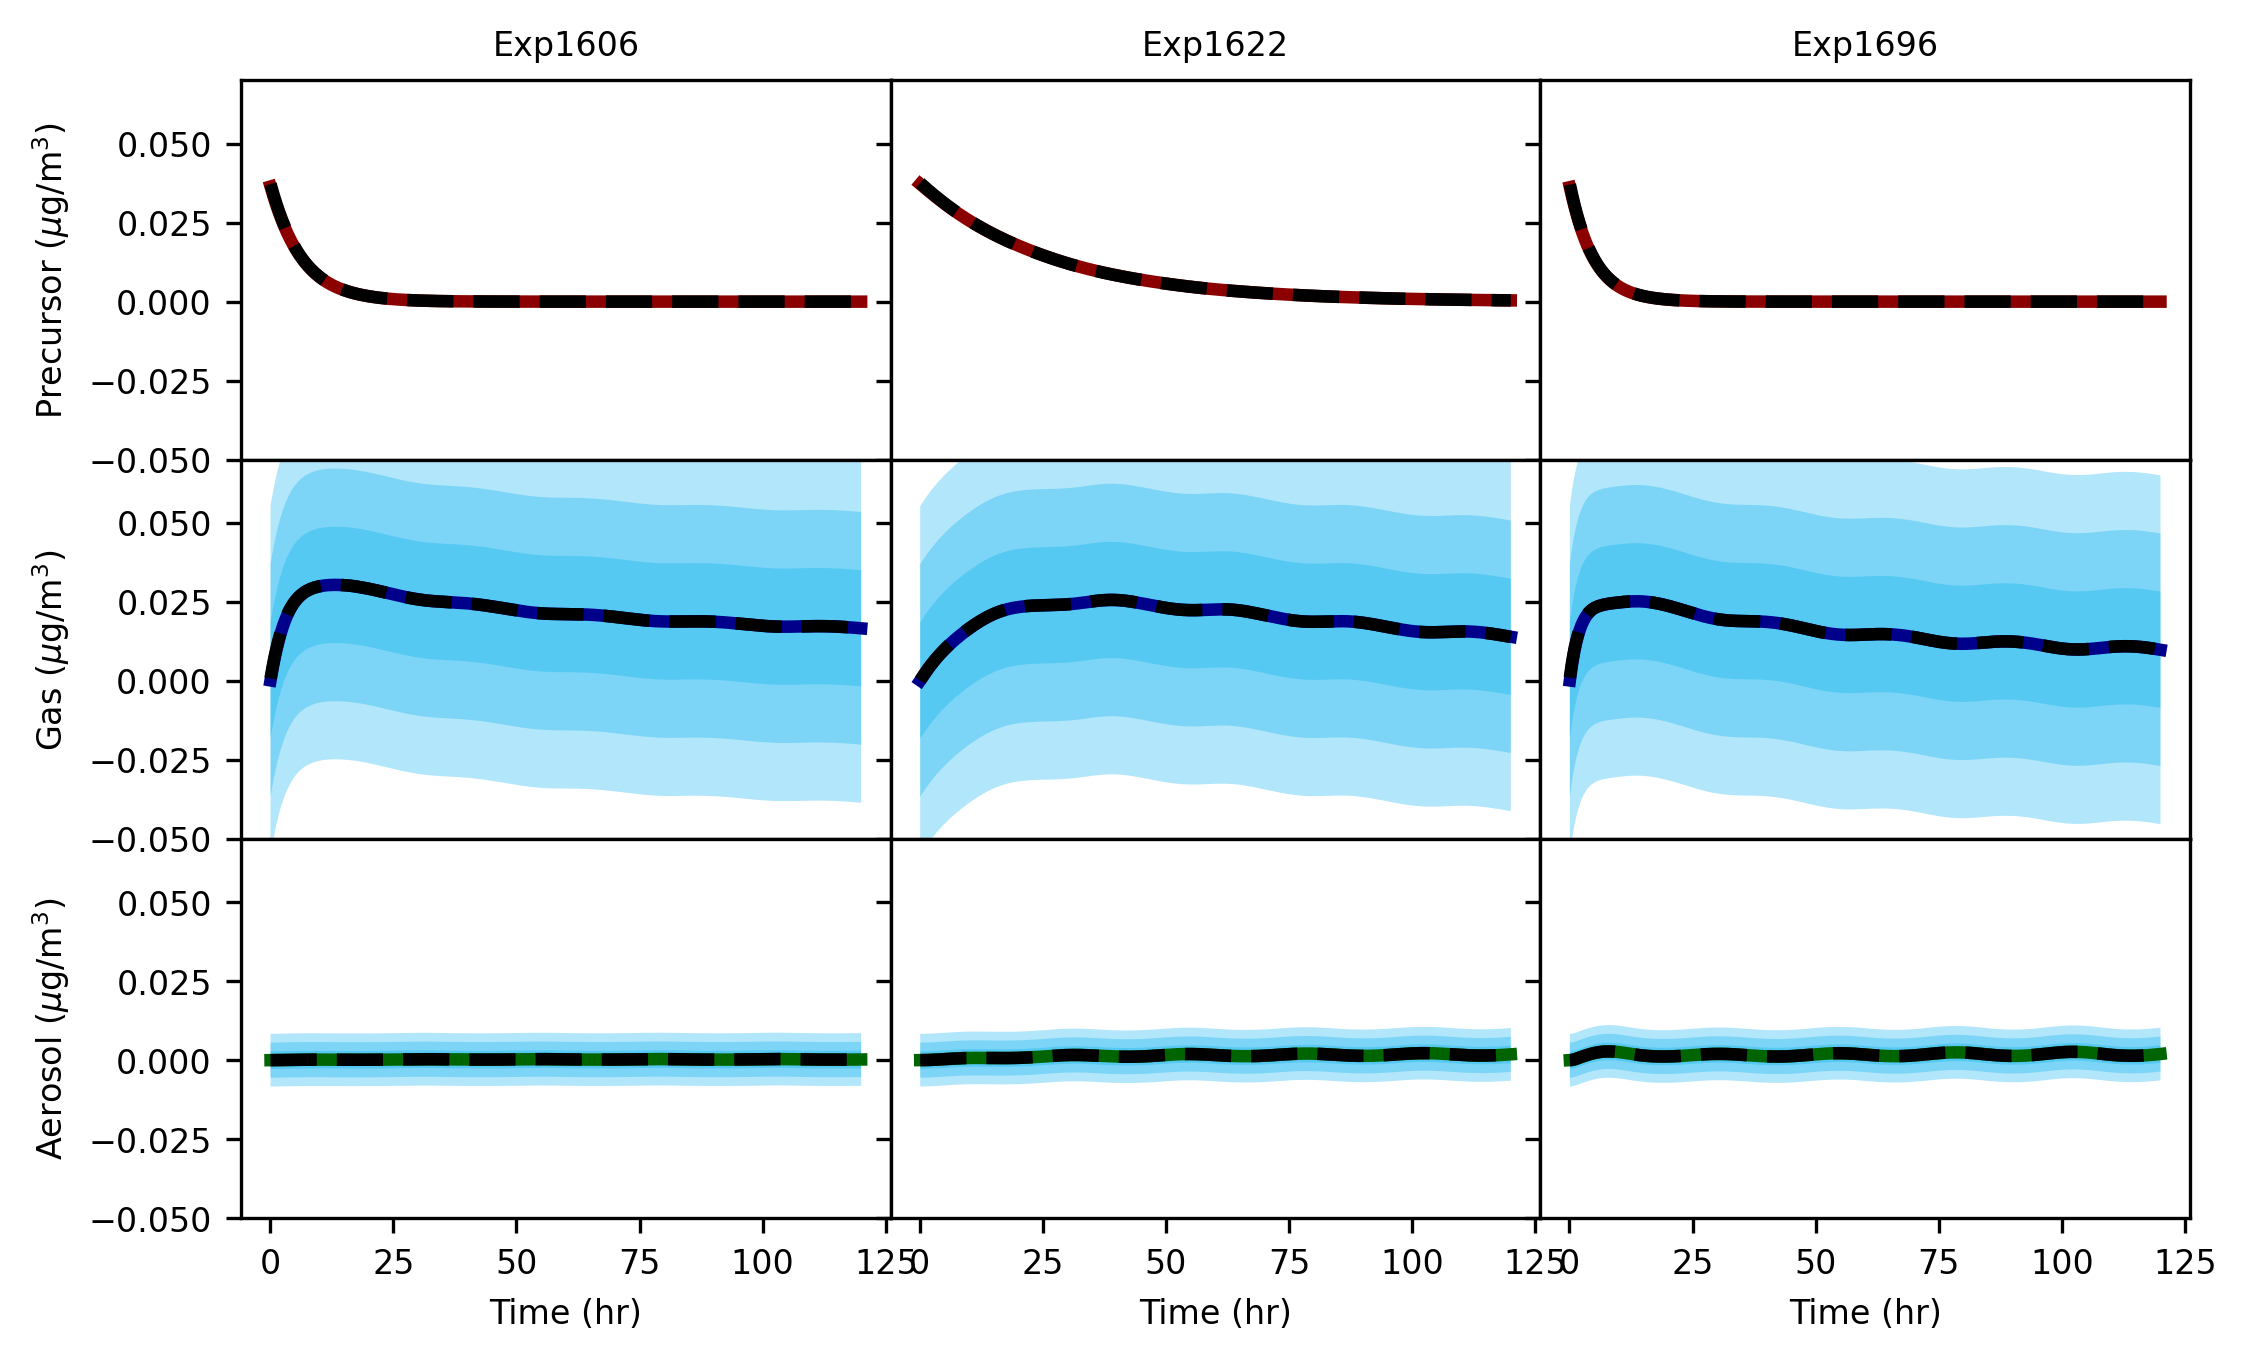

In [18]:
plot_ensemble(truth, preds, output_path, output_vars, species, "MLP", fontsize = 8)

In [54]:
preds["Precursor_error"] = abs(preds["Precursor [ug/m3]"] - truth["Precursor [ug/m3]"])
preds["Gas_error"] = abs(preds["Gas [ug/m3]"] - truth["Gas [ug/m3]"])
preds["Aerosol_error"] = abs(preds["Aerosol [ug_m3]"] - truth["Aerosol [ug_m3]"])

Text(0, 0.5, 'Mean absolute error')

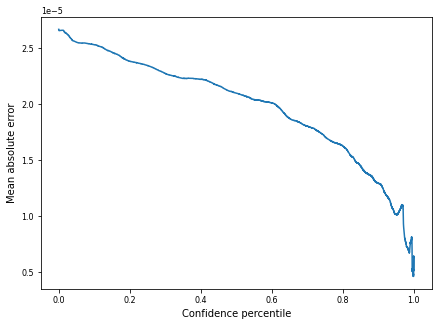

In [55]:
temp = preds.sort_values("Gas [ug/m3]_var", ascending = True).copy()
temp["dummy"] = 1
temp["MAE"] = temp["Gas_error"].cumsum() / temp["dummy"].cumsum()
temp["VAR"] = temp["Gas [ug/m3]_var"].cumsum() / temp["dummy"].cumsum()
temp["coverage"] = 1 - temp["dummy"].cumsum() / len(temp)

fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(1, 1, 1)

ax.plot(temp["coverage"], temp["MAE"])
#ax.plot(test_data["coverage"], test_data["MAPE"])

ax.set_xlabel("Confidence percentile")
ax.set_ylabel("Mean absolute error")

Text(0, 0.5, 'Observed confidence percentile (mae)')

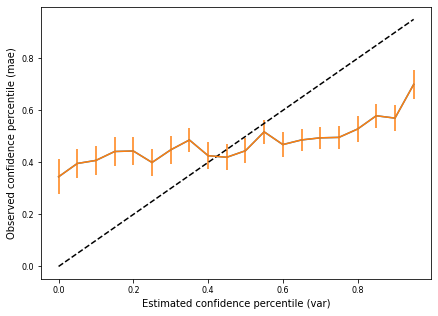

In [56]:
obs = temp.sort_values("Gas_error", ascending = True).copy()
obs["mae_cov"] = 1 - obs["dummy"].cumsum() / len(obs)
h, b1, b2, _ = ax.hist2d(obs["coverage"], obs["mae_cov"], bins = 20)
cov_var = np.arange(0, 1.0, 0.05)
cov_mae = [np.average(cov_var, weights = hi) for hi in h]
cov_std = [np.average((cov_mae-cov_var)**2, weights=hi) for hi in h]

fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(1, 1, 1)

ax.plot(cov_var, cov_mae)
ax.errorbar(cov_var, cov_mae, yerr = cov_std)
ax.plot(cov_var, cov_var, 'k--')

ax.set_xlabel("Estimated confidence percentile (var)")
ax.set_ylabel("Observed confidence percentile (mae)")

Text(0, 0.5, 'Mean absolute error')

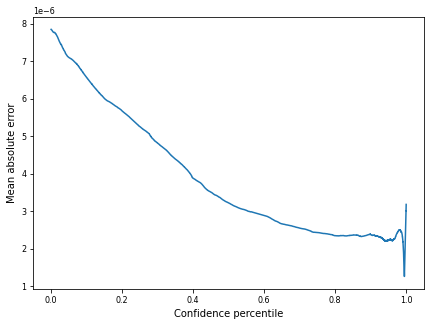

In [57]:
temp = preds.sort_values("Aerosol [ug_m3]_var", ascending = True).copy()
temp["dummy"] = 1
temp["MAE"] = temp["Aerosol_error"].cumsum() / temp["dummy"].cumsum()
temp["VAR"] = temp["Aerosol [ug_m3]_var"].cumsum() / temp["dummy"].cumsum()
temp["coverage"] = 1 - temp["dummy"].cumsum() / len(temp)

fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(1, 1, 1)

ax.plot(temp["coverage"], temp["MAE"])
#ax.plot(test_data["coverage"], test_data["MAPE"])

ax.set_xlabel("Confidence percentile")
ax.set_ylabel("Mean absolute error")

Text(0, 0.5, 'Observed confidence percentile (mae)')

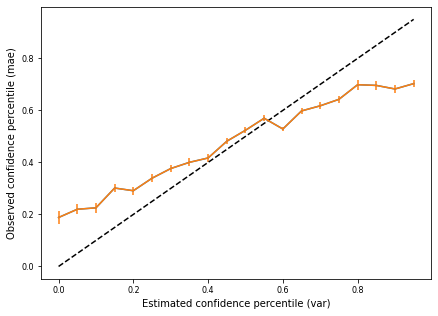

In [58]:
obs = temp.sort_values("Aerosol_error", ascending = True).copy()
obs["mae_cov"] = 1 - obs["dummy"].cumsum() / len(obs)
h, b1, b2, _ = ax.hist2d(obs["coverage"], obs["mae_cov"], bins = 20)
cov_var = np.arange(0, 1.0, 0.05)
cov_mae = [np.average(cov_var, weights = hi) for hi in h]
cov_std = [np.average((cov_mae-cov_var)**2, weights=hi) for hi in h]

fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(1, 1, 1)

ax.plot(cov_var, cov_mae)
ax.errorbar(cov_var, cov_mae, yerr = cov_std)
ax.plot(cov_var, cov_var, 'k--')

ax.set_xlabel("Estimated confidence percentile (var)")
ax.set_ylabel("Observed confidence percentile (mae)")

### Now evaluate on-line

In [61]:
val_loss = []
_in_array = torch.from_numpy(val_in_array).float()#.to(device).float()

model.eval()
with torch.no_grad():
    # set up array for saving predicted results
    pred_array = np.empty((val_in_array.shape[0], num_timesteps-start_time, len(out_col_idx)))
    var_pred_array = np.empty((val_in_array.shape[0], num_timesteps-start_time, len(out_col_idx)))

    # use initial condition @ t = start_time and get the first prediction
    gamma, v, alpha, beta = model(_in_array[:, start_time, :].to(device))
    pred_array[:, 0, :] = gamma.cpu().numpy()
    var_pred_array[:, 0, :] = np.sqrt(beta.cpu().numpy() / (v.cpu().numpy() * (alpha.cpu().numpy() - 1)))
    loss = torch.nn.functional.l1_loss(_in_array[:, start_time + 1, out_col_idx], gamma.cpu()).item()
    val_loss.append(loss)

    # use the first prediction to get the next, and so on for num_timesteps
    for k, i in enumerate(range(start_time + 1, num_timesteps)): 
        new_input = _in_array[:, i, :]
        new_input[:, out_col_idx] = gamma.cpu()
        gamma, v, alpha, beta = model(new_input.to(device))
        pred_array[:, k+1, :] = gamma.cpu().numpy()
        var_pred_array[:, k+1, :] = np.sqrt(beta.cpu().numpy() / (v.cpu().numpy() * (alpha.cpu().numpy() - 1)))
        if i < (num_timesteps-1):
            loss = torch.nn.functional.l1_loss(_in_array[:, i+1, out_col_idx], gamma.cpu()).item()
            val_loss.append(loss)

In [62]:
idx = transformed_data["val_out"].index
start_time_units = sorted(list(set([x[0] for x in idx])))[start_time]
start_time_condition = [(x[0] >= start_time_units) for x in idx]
idx = transformed_data["val_out"][start_time_condition].index

raw_box_preds = pd.DataFrame(
    data=pred_array.reshape(-1, len(output_vars)),
    columns=output_vars, 
    index=idx
)

raw_box_vars = pd.DataFrame(
    data=var_pred_array.reshape(-1, len(output_vars)),
    columns=output_vars, 
    index=idx
)

# inverse transform 
truth, preds = inv_transform_preds(
    raw_preds=raw_box_preds,
    truth=data['val_out'][start_time_condition],
    y_scaler=y_scaler,
    log_trans_cols=log_trans_cols,
    tendency_cols=tendency_cols)

_, pred_vars = inv_transform_preds(
    raw_preds=raw_box_vars,
    truth=data['val_out'][start_time_condition],
    y_scaler=y_scaler,
    log_trans_cols=log_trans_cols,
    tendency_cols=tendency_cols)

for col in output_vars:
    preds[col + "_var"] = pred_vars[col].copy()

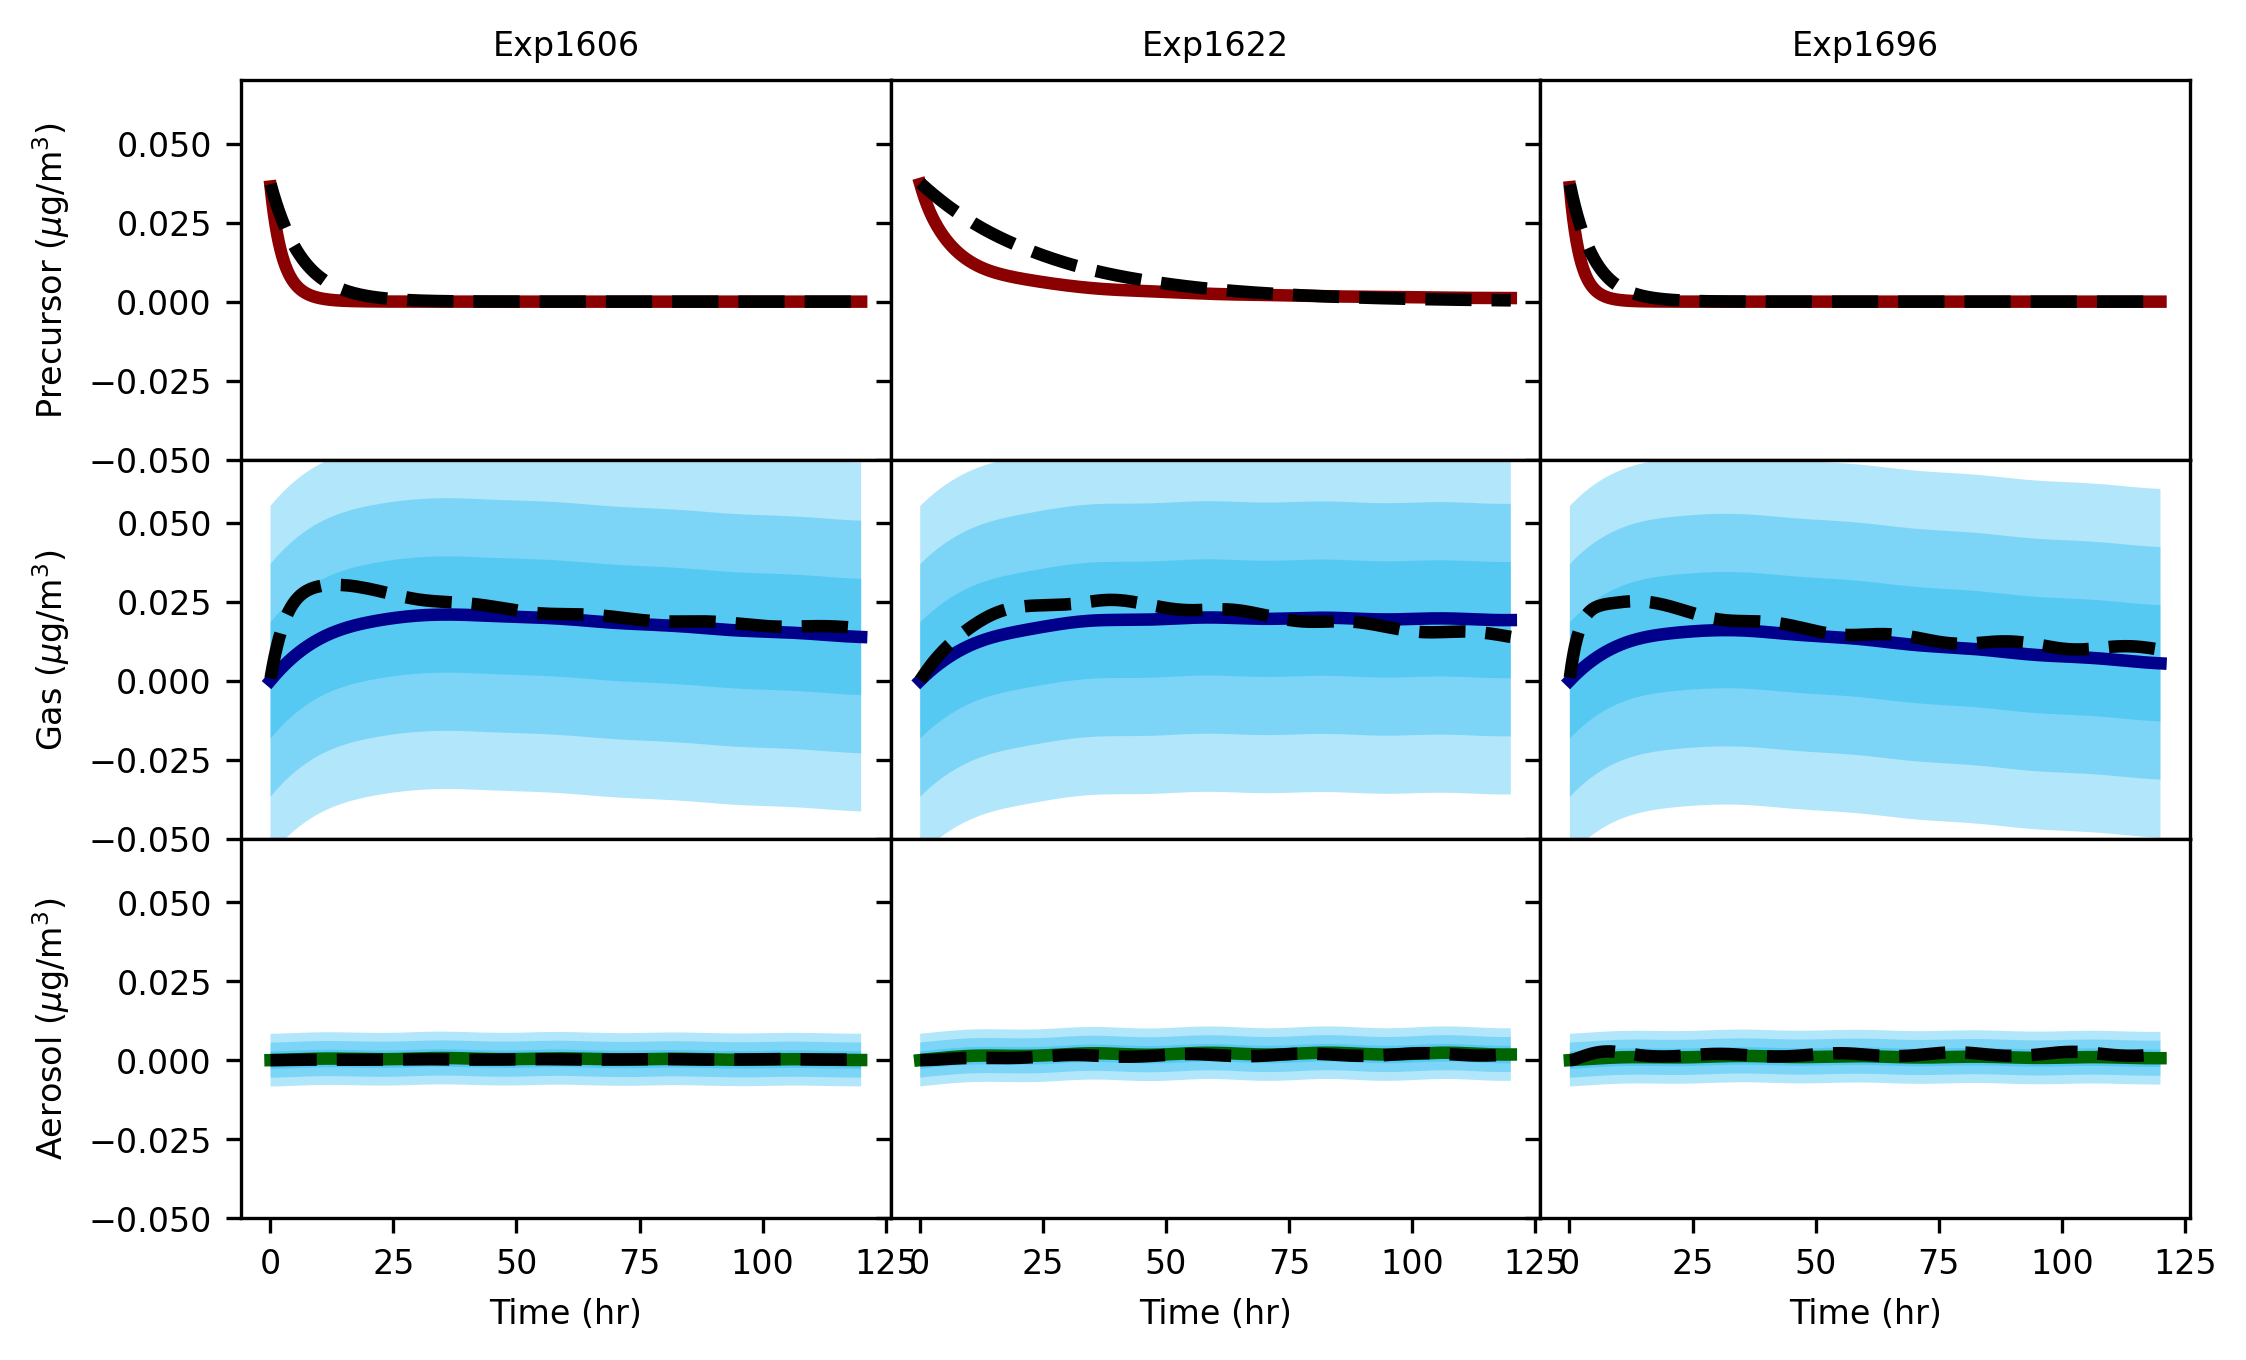

In [63]:
plot_ensemble(truth, preds, output_path, output_vars, species, "MLP", fontsize = 8)

In [64]:
preds["Precursor_error"] = abs(preds["Precursor [ug/m3]"] - truth["Precursor [ug/m3]"])
preds["Gas_error"] = abs(preds["Gas [ug/m3]"] - truth["Gas [ug/m3]"])
preds["Aerosol_error"] = abs(preds["Aerosol [ug_m3]"] - truth["Aerosol [ug_m3]"])

Text(0, 0.5, 'Mean absolute error')

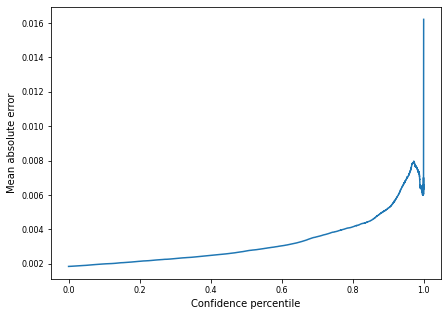

In [75]:
temp = preds.sort_values("Precursor [ug/m3]_var", ascending = True).copy()
temp["dummy"] = 1
temp["MAE"] = temp["Precursor_error"].cumsum() / temp["dummy"].cumsum()
temp["VAR"] = temp["Precursor [ug/m3]_var"].cumsum() / temp["dummy"].cumsum()
temp["coverage"] = 1 - temp["dummy"].cumsum() / len(temp)

fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(1, 1, 1)

ax.plot(temp["coverage"], temp["MAE"])
#ax.plot(test_data["coverage"], test_data["MAPE"])

ax.set_xlabel("Confidence percentile")
ax.set_ylabel("Mean absolute error")

Text(0, 0.5, 'Observed confidence percentile (mae)')

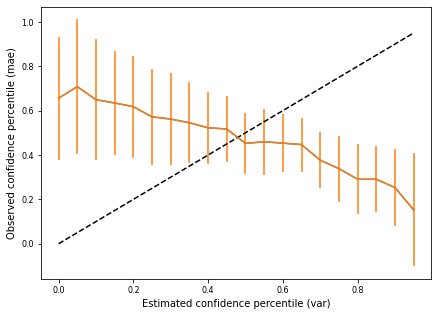

In [76]:
obs = temp.sort_values("Precursor_error", ascending = True).copy()
obs["mae_cov"] = 1 - obs["dummy"].cumsum() / len(obs)
h, b1, b2, _ = ax.hist2d(obs["coverage"], obs["mae_cov"], bins = 20)
cov_var = np.arange(0, 1.0, 0.05)
cov_mae = [np.average(cov_var, weights = hi) for hi in h]
cov_std = [np.average((cov_mae-cov_var)**2, weights=hi) for hi in h]

fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(1, 1, 1)

ax.plot(cov_var, cov_mae)
ax.errorbar(cov_var, cov_mae, yerr = cov_std)
ax.plot(cov_var, cov_var, 'k--')

ax.set_xlabel("Estimated confidence percentile (var)")
ax.set_ylabel("Observed confidence percentile (mae)")

Text(0, 0.5, 'Mean absolute error')

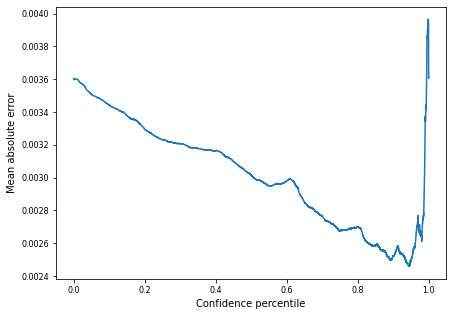

In [77]:
temp = preds.sort_values("Gas [ug/m3]_var", ascending = True).copy()
temp["dummy"] = 1
temp["MAE"] = temp["Gas_error"].cumsum() / temp["dummy"].cumsum()
temp["VAR"] = temp["Gas [ug/m3]_var"].cumsum() / temp["dummy"].cumsum()
temp["coverage"] = 1 - temp["dummy"].cumsum() / len(temp)

fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(1, 1, 1)

ax.plot(temp["coverage"], temp["MAE"])
#ax.plot(test_data["coverage"], test_data["MAPE"])

ax.set_xlabel("Confidence percentile")
ax.set_ylabel("Mean absolute error")

Text(0, 0.5, 'Observed confidence percentile (mae)')

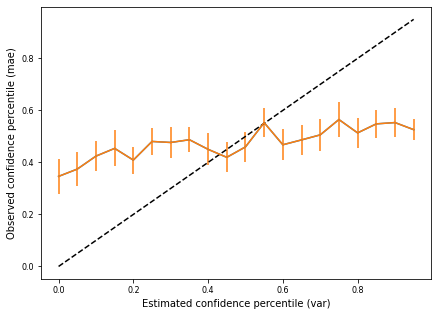

In [78]:
obs = temp.sort_values("Gas_error", ascending = True).copy()
obs["mae_cov"] = 1 - obs["dummy"].cumsum() / len(obs)
h, b1, b2, _ = ax.hist2d(obs["coverage"], obs["mae_cov"], bins = 20)
cov_var = np.arange(0, 1.0, 0.05)
cov_mae = [np.average(cov_var, weights = hi) for hi in h]
cov_std = [np.average((cov_mae-cov_var)**2, weights=hi) for hi in h]

fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(1, 1, 1)

ax.plot(cov_var, cov_mae)
ax.errorbar(cov_var, cov_mae, yerr = cov_std)
ax.plot(cov_var, cov_var, 'k--')

ax.set_xlabel("Estimated confidence percentile (var)")
ax.set_ylabel("Observed confidence percentile (mae)")

Text(0, 0.5, 'Mean absolute error')

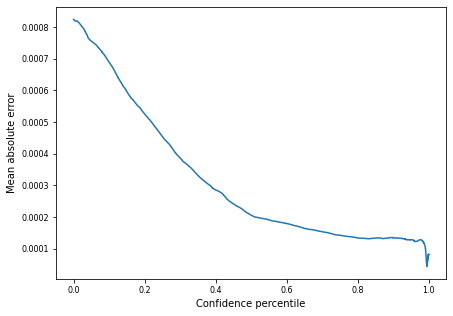

In [79]:
temp = preds.sort_values("Aerosol [ug_m3]_var", ascending = True).copy()
temp["dummy"] = 1
temp["MAE"] = temp["Aerosol_error"].cumsum() / temp["dummy"].cumsum()
temp["VAR"] = temp["Aerosol [ug_m3]_var"].cumsum() / temp["dummy"].cumsum()
temp["coverage"] = 1 - temp["dummy"].cumsum() / len(temp)

fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(1, 1, 1)

ax.plot(temp["coverage"], temp["MAE"])
#ax.plot(test_data["coverage"], test_data["MAPE"])

ax.set_xlabel("Confidence percentile")
ax.set_ylabel("Mean absolute error")

Text(0, 0.5, 'Observed confidence percentile (mae)')

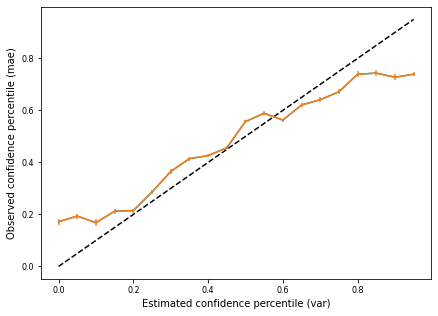

In [80]:
obs = temp.sort_values("Aerosol_error", ascending = True).copy()
obs["mae_cov"] = 1 - obs["dummy"].cumsum() / len(obs)
h, b1, b2, _ = ax.hist2d(obs["coverage"], obs["mae_cov"], bins = 20)
cov_var = np.arange(0, 1.0, 0.05)
cov_mae = [np.average(cov_var, weights = hi) for hi in h]
cov_std = [np.average((cov_mae-cov_var)**2, weights=hi) for hi in h]

fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(1, 1, 1)

ax.plot(cov_var, cov_mae)
ax.errorbar(cov_var, cov_mae, yerr = cov_std)
ax.plot(cov_var, cov_var, 'k--')

ax.set_xlabel("Estimated confidence percentile (var)")
ax.set_ylabel("Observed confidence percentile (mae)")